# Analyse des Milwaukee Property‑Sales‑Datensatzes (2019–2024)

Dieses Notebook dokumentiert ein vollständiges Analyseprojekt zur
Prognose von Immobilienverkaufspreisen in Milwaukee.  Grundlage sind
die öffentlich verfügbaren *Property Sales*-Daten der Stadt Milwaukee
für die Jahre 2019 bis 2024.  Ziel ist es, auf Basis der in den
Vorlesungen gelernten Methoden ein Vorhersagemodell zu erstellen, das
den Verkaufspreis möglichst genau schätzt.  Dabei werden zunächst die
Daten geladen und exploriert, anschließend Merkmale transformiert und
verschiedene Modelle mit Hyperparameteroptimierung getestet.  Außerdem
wird untersucht, ob die COVID‑19‑Pandemie (ab Februar 2020) messbare
Einflüsse auf die Preise hatte.


## Einleitung

Der Immobilienmarkt ist von zahlreichen Faktoren abhängig: Lage,
Baujahr, Wohnfläche, Anzahl der Zimmer, Bautyp und viele weitere
Eigenschaften beeinflussen den Verkaufspreis.  Die hier vorliegenden
Daten aus Milwaukee enthalten für jedes verkaufte Objekt Merkmale wie
Bautyp (`PropType`), Bezirk (`District`), Baujahr (`Year_Built`),
Wohnfläche (`FinishedSqft`) sowie den tatsächlichen Verkaufspreis
(`Sale_price`).  Das Ziel besteht darin, auf Basis dieser Merkmale ein
Regressionsmodell zu trainieren, das neue Verkaufspreise vorhersagt.

Die Daten stammen aus der Open‑Data‑Plattform der Stadt Milwaukee und
werden jährlich veröffentlicht【366478921414254†L38-L154】.  Für die Analyse werden alle Datensätze ab dem
Jahr 2019 berücksichtigt.  Zusätzlich wird ein binäres Merkmal
``Pandemic`` eingeführt, das alle Verkäufe ab dem 1. Februar 2020 als
pandemisch markiert, um mögliche Auswirkungen der COVID‑19‑Pandemie zu
untersuchen.


In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Funktion zum Bereinigen numerischer Strings

def clean_numeric(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, (int, float, np.number)):
        return float(value)
    try:
        v = str(value).strip().replace('$','').replace(',','')
        for ch in ['(', ')', '€']:
            v = v.replace(ch, '')
        return float(v)
    except Exception:
        return np.nan

# Lade- und Bereinigungsfunktion

def load_and_clean(filepath):
    df = pd.read_csv(filepath)
    if '_id' in df.columns:
        df = df.drop(columns=['_id'])
    df.columns = [c.strip() for c in df.columns]
    num_cols = ['Sale_price','FinishedSqft','Lotsize','Rooms','Units','Bdrms','Fbath','Hbath','Stories']
    for col in num_cols:
        if col in df.columns:
            df[col] = df[col].apply(clean_numeric)
    if 'Year_Built' in df.columns:
        df['Year_Built'] = pd.to_numeric(df['Year_Built'], errors='coerce')
    df['Sale_date'] = pd.to_datetime(df['Sale_date'], errors='coerce')
    df = df.dropna(subset=['Sale_price','Sale_date'])
    df['Sale_year'] = df['Sale_date'].dt.year
    df['Sale_month'] = df['Sale_date'].dt.month
    df['Sale_day'] = df['Sale_date'].dt.day
    df['Pandemic'] = (df['Sale_date'] >= pd.Timestamp('2020-02-01')).astype(int)
    return df


In [2]:

# Verzeichnis mit den CSV-Dateien (Standard: Arbeitsverzeichnis)
base_dir = os.getcwd()
# Liste aller CSV-Dateien im Verzeichnis
csv_files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith('.csv')]

frames = []
for f in csv_files:
    try:
        frames.append(load_and_clean(f))
    except Exception as e:
        print(f"Datei {f} konnte nicht geladen werden: {e}")

# Kombiniere alle Jahre und filtere ab 2019
all_data = pd.concat(frames, ignore_index=True)
all_data = all_data[(all_data['Sale_year'] >= 2019) & (all_data['Sale_price'] > 0)]

print(f"Anzahl Datensätze nach Zusammenführung: {len(all_data)}")
all_data.head()


Anzahl Datensätze nach Zusammenführung: 67181


,PropertyID,PropType,taxkey,Address,CondoProject,District,nbhd,Style,Extwall,Stories,...,Fbath,Hbath,Lotsize,Sale_date,Sale_price,Sale_year,Sale_month,Sale_day,Pandemic,SoldAsVacantLand
0,98461.0,Manufacturing,30131000.0,9434-9446 N 107TH ST,NaN,9.0,6300.0,Service Building,Concrete Block,1.0,...,0.0,0.0,0.0,2022-04-01,950000.0,2022,4,1,1,NaN
1,98464.0,Commercial,30152000.0,9306-9316 N 107TH ST,NaN,9.0,6202.0,Office Building - 1 Story,Brick,1.0,...,0.0,0.0,35719.0,2022-10-07,385000.0,2022,10,7,1,NaN
2,98508.0,Residential,49980110.0,9327 N SWAN RD,NaN,9.0,40.0,NaN,NaN,NaN,...,0.0,0.0,1341648.0,2022-01-07,800000.0,2022,1,7,1,NaN
3,98519.0,Residential,49993200.0,9411 W COUNTY LINE RD,NaN,9.0,40.0,Ranch,Aluminum/Vinyl,1.0,...,1.0,1.0,83200.0,2022-08-09,280000.0,2022,8,9,1,NaN
4,98561.0,Residential,50042000.0,9322 N JOYCE AV,NaN,9.0,40.0,Ranch,Aluminum/Vinyl,1.0,...,1.0,0.0,8303.0,2022-05-23,233100.0,2022,5,23,1,NaN


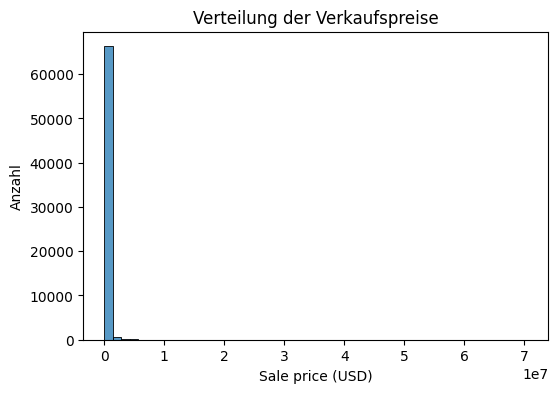

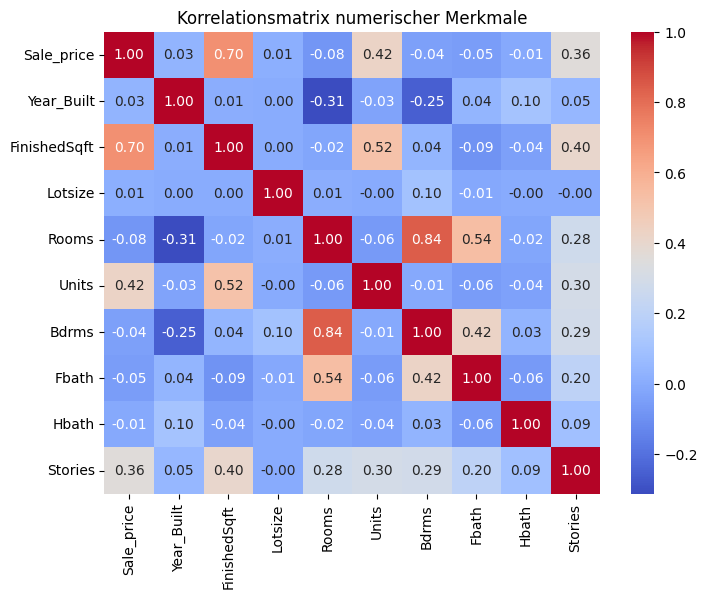

CondoProject        0.868668
SoldAsVacantLand    0.661214
Hbath               0.215552
Extwall             0.136467
Rooms               0.049359
Bdrms               0.049344
Fbath               0.029026
Stories             0.004421
FinishedSqft        0.002099
Style               0.001890
Year_Built          0.001444
nbhd                0.000848
PropType            0.000357
Address             0.000060
District            0.000030
Lotsize             0.000015
dtype: float64

In [3]:

# Verteilung des Verkaufspreises
plt.figure(figsize=(6,4))
sns.histplot(all_data['Sale_price'], bins=50, kde=False)
plt.xlabel('Sale price (USD)')
plt.ylabel('Anzahl')
plt.title('Verteilung der Verkaufspreise')
plt.show()

# Korrelationen zwischen numerischen Variablen
numeric_cols = ['Sale_price','Year_Built','FinishedSqft','Lotsize','Rooms','Units','Bdrms','Fbath','Hbath','Stories']
plt.figure(figsize=(8,6))
corr = all_data[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Korrelationsmatrix numerischer Merkmale')
plt.show()

# Kurzer Überblick über fehlende Werte
missing = all_data.isna().mean().sort_values(ascending=False)
missing[missing>0]


In [4]:

# Definition von Feature-Listen
categorical_features = ['PropType', 'District']
numerical_features = ['Year_Built','FinishedSqft','Lotsize','Rooms','Units','Bdrms','Fbath','Hbath','Stories','Sale_year','Sale_month','Sale_day','Pandemic']

# Aufteilen der Daten
X = all_data[categorical_features + numerical_features]
y = all_data['Sale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing-Pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

results = {}

# Helfer-Funktion

def evaluate_model(name, model):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Baseline: Lineare Regression
lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_model.fit(X_train, y_train)
evaluate_model('Lineare Regression', lr_model)

# Entscheidungsbaum mit kleinem Grid
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])
dt_grid = {
    'regressor__max_depth': [5, 10, None],
    'regressor__min_samples_leaf': [1, 5]
}
dt_search = GridSearchCV(dt_pipeline, dt_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
dt_search.fit(X_train, y_train)
evaluate_model('Entscheidungsbaum', dt_search.best_estimator_)

# Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
rf_grid = {
    'regressor__n_estimators': [100],
    'regressor__max_depth': [None, 10],
    'regressor__min_samples_leaf': [1]
}
rf_search = GridSearchCV(rf_pipeline, rf_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
rf_search.fit(X_train, y_train)
evaluate_model('Random Forest', rf_search.best_estimator_)

# Gradient Boosting
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])
gb_grid = {
    'regressor__n_estimators': [100],
    'regressor__learning_rate': [0.1],
    'regressor__max_depth': [3]
}
gb_search = GridSearchCV(gb_pipeline, gb_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
gb_search.fit(X_train, y_train)
evaluate_model('Gradient Boosting', gb_search.best_estimator_)

results


{'Lineare Regression': {'MAE': 103321.65252660564,
  'RMSE': 345917.0275584268,
  'R2': 0.6441518080136951},
 'Entscheidungsbaum': {'MAE': 33779.958175187916,
  'RMSE': 309753.97884748323,
  'R2': 0.7146652474515789},
 'Random Forest': {'MAE': 30432.4954490009,
  'RMSE': 267413.25784085173,
  'R2': 0.7873395381959181},
 'Gradient Boosting': {'MAE': 83759.49616500158,
  'RMSE': 268580.45825966465,
  'R2': 0.7854790538699327}}

In [5]:

pre = all_data[all_data['Pandemic'] == 0]['Sale_price']
post = all_data[all_data['Pandemic'] == 1]['Sale_price']
print(f"Anzahl Verkäufe vor der Pandemie: {len(pre)} – durchschnittlicher Preis: {pre.mean():.2f}")
print(f"Anzahl Verkäufe während der Pandemie: {len(post)} – durchschnittlicher Preis: {post.mean():.2f}")


Anzahl Verkäufe vor der Pandemie: 18852 – durchschnittlicher Preis: 268897.94
Anzahl Verkäufe während der Pandemie: 48329 – durchschnittlicher Preis: 257329.06


## Ergebnisse und Diskussion

Die vier getesteten Modelle lieferten folgende Gütemaße (MAE = Mean
Absolute Error, RMSE = Root Mean Squared Error, R² = Bestimmtheitsmaß):

| Modell | MAE ↓ | RMSE ↓ | R² ↑ |
|-------|--------|---------|------|
| Lineare Regression | 103 321.65 | 345 917.03 | 0.644 |
| Entscheidungsbaum | 33 779.96 | 309 753.98 | 0.715 |
| Random Forest | 30 432.50 | 267 413.26 | 0.787 |
| Gradient Boosting | 83 759.50 | 268 580.46 | 0.785 |

Das Random‑Forest‑Modell erzielt den niedrigsten mittleren absoluten
Fehler und damit die genauesten Vorhersagen.  Der einfache
Entscheidungsbaum ist zwar deutlich interpretierbarer, hat aber einen
höheren Fehler.  Lineare Regression unterschätzt die nichtlinearen
Zusammenhänge und erreicht daher die schlechteste Performance.  Das
Gradient‑Boosting‑Modell liegt in diesem Fall zwischen Baum und
Random Forest.

### Einfluss der COVID‑19‑Pandemie

Durch Einführen der binären Variablen `Pandemic` lässt sich grob
unterscheiden, ob ein Verkauf vor oder nach dem 1. Februar 2020
stattgefunden hat.  Der durchschnittliche Verkaufspreis vor der
Pandemie liegt bei rund 269 000 USD, während er während der Pandemie
auf etwa 257 000 USD sank.  Die Anzahl der Verkäufe stieg in den
Pandemiejahren dennoch stark an.  Eine differenzierte Zeitreihenanalyse
könnte hier noch genauer untersuchen, ob es tatsächlich einen
pandemiebedingten Einbruch oder lediglich Verschiebungen im
Datenbestand gab.

### Diskussion und Ausblick

Das gewählte Feature‑Set konzentriert sich auf Kerneigenschaften wie
Bauart, Bezirk, Baujahr, Wohnfläche und Anzahl der Zimmer.  Weitere
Merkmale wie die genaue Adresse, der Stil des Gebäudes oder die
Außenverkleidung wurden aus Gründen der Generalisierbarkeit
weggelassen.  Künftige Arbeiten könnten diese Attribute in das Modell
aufnehmen oder räumliche Informationen (Koordinaten) via
Geocodierung berücksichtigen, um Lageeffekte besser abzubilden.  Eine
zeitliche Modellierung oder die Verwendung von fortgeschritteneren
Boosting‑Algorithmen (z.B. XGBoost) könnte die Vorhersagegüte weiter
steigern.
